In [1]:
from model_functions import *
from param_functions import *
import numpy as np
import pandas as pd
from IPython import display as ipd
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
import string
mpl.rcParams['figure.dpi'] = 400

# %matplotlib qt


-----------

## Cable Materials

In [3]:
therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [4]:
cables = ['119-SS-SS', '119-CuNi-CuNi', '219-SS-SS', '219-CuNi-CuNi', '119-NbTi-NbTi', '219-NbTi-NbTi']

c_p = np.array(fridge_ours['cool_p'])

load_matrices = []
att_loads = []

for c in cables:

    c_drive = c
    c_flux = c
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    att = np.array([0, 20, 0, 20, 20])
    c_att = coax_co_params[c_drive]['att_4'](6) * np.array(fridge_ours['lengths'])
    total_att = np.sum(att + c_att)

    p_in = 1e-3*10**((total_att-64)/10)

    p = [p_in]
    for i in range(1, 5):
        p.append(p[i-1]*10**(-(att+c_att)[i-1]/10))

    a_ac = np.array(p) * (1 - 10**(-c_att/10))
    a_ac = pd.Series(a_ac, index=fridge_ours['labels'])
    att_loads.append(np.array(p) * (1 - 10**(-att/10)))

    cable_rho = coax_co_params[c_flux]['rho'] 
    lengths = fridge_ours['lengths']
    diameters = coax_co_params[c_flux]['d']
    A_inner = np.pi*(diameters[0]/2)**2

    R_CP =  (
        0.42
        * (cable_rho / 7.2e-7)
        * (lengths[-2]/0.17)
        * (np.pi*(0.511e-3/2)**2 / A_inner)
    )
    R_MXC =  (
        0.15
        * (cable_rho / 7.2e-7)
        * (lengths[-1]/0.14)
        * (np.pi*(0.511e-3/2)**2 / A_inner)
    )

    R_eff = [0, 0, 0, R_CP, R_MXC]
    I = [0.02, 0.02, 0.002, 0.002, 0.002]
    a_dc = np.array(I)**2 * np.array(R_eff)
    a_dc = pd.Series(a_dc, index=fridge_ours['labels'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14, p_flux*14, a_ac*14*0.33, a_dc*14], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Active (Drive)', 'Active (Flux)']
    )
    load_matrices.append(load_matrix)

In [7]:
load_matrices[0].iloc[[0, 1], 0].sum()

0.14844985680772443

In [4]:
load_matrices[0]

,50K,4K,Still,CP,MXC
Passive (Drive),0.074225,0.006078,0.000009,0.000003,2.290802e-08
Passive (Flux),0.074225,0.006078,0.000009,0.000002,7.311351e-07
Active (Drive),0.001687,0.001165,0.000005,0.000001,1.136877e-08
Active (Flux),0.000000,0.000000,0.000000,0.000066,4.222622e-05


In [7]:
load_matrices[4]

,50K,4K,Still,CP,MXC
Passive (Drive),0.042398,0.003472,0.000005,0.000002,1.308534e-08
Passive (Flux),0.042398,0.003472,0.000005,0.000001,4.176332e-07
Active (Drive),0.000000,0.000000,0.000000,0.000000,0.000000e+00
Active (Flux),0.000000,0.000000,0.000000,0.000000,0.000000e+00


In [22]:
#plot 1 - raw data
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(4, 7))

colours = ["#FF4444", "#4474FF"]

for stage in range(5):
    for cable in range(len(cables)):
        for load in range(2):
            if load == 0: val = load_matrices[cable].iloc[[0, 1], stage].sum()
            if load == 1: val = load_matrices[cable].iloc[[2, 3], stage].sum()
            if (stage == 0 or stage == 1) and (cable == 4 or cable == 5): val = 0
            axs[stage].bar(cable*3+load, val, width=1, color=colours[load])

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylim(1e-7, 1e0)
    ax.set_xticks([0.5+3*i for i in range(len(cables))])
    ax.set_yticks([10**(i) for i in range(-7, 1)], minor=True)
    ax.set_yticks([1e-6, 1e-3, 1e0], minor=False)
    ax.set_yticklabels([], minor=True)
    ax.grid(True, 'major', 'y', alpha=0.6, linewidth=1.5)
    ax.grid(True, 'minor', 'y', alpha=0.4)

axs[2].set_ylabel('Heat Power (W)')
axs[-1].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi', '1.19mm NbTi', '2.19mm NbTi'], rotation=90)
axs[-1].set_xlabel('Cable')
axs[2].legend(['Conduction', 'Dissipation'], fontsize=9)
plt.tight_layout(True)

plt.savefig('Cable Raw Heat.png', dpi=400, transparent=True)

plt.show()


In [43]:
#plot 2 - as a proportion of the heat budgets
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(4, 7))

c_p = np.array(fridge_ours['cool_p'])
colours = ["#FF4444", "#4474FF"]

for stage in range(5):
    for cable in range(len(cables)):
        for load in range(2):
            if load == 0: val = load_matrices[cable].iloc[[0, 1], stage].sum()/c_p[stage]
            if load == 1: val = load_matrices[cable].iloc[[2, 3], stage].sum()/c_p[stage]
            if (stage == 0 or stage == 1) and (cable == 4 or cable == 5): val = 0
            axs[stage].bar(cable*3+load, val, width=1, color=colours[load])

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylim(1e-5, 3)
    ax.set_xticks([0.5+3*i for i in range(len(cables))])
    ax.set_yticks([10**(i) for i in range(-5, 1)], minor=True)
    ax.set_yticks([1e-3, 1e0], minor=False)
    ax.set_yticklabels([], minor=True)
    ax.grid(True, 'major', 'y', alpha=0.6, linewidth=1.5)
    ax.grid(True, 'minor', 'y', alpha=0.4)
    ax.axhline(1, 0.05, 0.95, linestyle='dashed', c='k', linewidth=1)

axs[2].set_ylabel('Heat Power\n'+ r'$P/P_\mathrm{cooling}$')
axs[-1].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi', '1.19mm NbTi', '2.19mm NbTi'], rotation=90)
axs[-1].set_xlabel('Cable')
l = axs[2].legend([1, 2, 3], fontsize=9)
axs[2].legend(handles=l.legendHandles[1:], labels=['Conduction', 'Dissipation'], fontsize=9, loc='upper right')
plt.tight_layout(True)

plt.savefig('Cable proportional.png', dpi=400, transparent=True)

plt.show()


In [9]:
#plot 3 - zoom in on MXC
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(6, 2.8))

c_p = np.array(fridge_ours['cool_p'])
colours = ["#FF4444", "#FFB544", "#36CE5B", "#4474FF"]

for cable in range(6):
    for load in range(4):
        val = load_matrices[cable].iloc[load, 4].sum()/c_p[4]
        axs[0].bar(-0.25+cable*3+load*0.5, val, width=0.5, color=colours[load])
    for line in range(2):
        if line== 0: 
            val = load_matrices[cable].iloc[[0, 2], 4].sum()/c_p[4]
            col = "#FF4444"
        if line == 1: 
            val = load_matrices[cable].iloc[[1, 3], 4].sum()/c_p[4]
            col = "#4474FF"
        axs[1].bar(cable*3+line, val, width=1, color=col)

for ax in axs:
    ax.set_yscale('log')
    ax.set_ylim(5e-4, 3)
    ax.set_xticks([0.5+3*i for i in range(6)])
    ax.set_yticks([10**(i) for i in range(-4, 1)], minor=True)
    ax.set_yticks([1e-3, 1e0], minor=False)
    ax.set_yticklabels([], minor=True)
    ax.set_xticklabels([])
    ax.grid(True, 'major', 'y', alpha=0.6, linewidth=1.5)
    ax.grid(True, 'minor', 'y', alpha=0.4)
    ax.axhline(1, 0.05, 0.95, linestyle='dashed', c='k', linewidth=1)

# ax.set_xticks([0.75+3*i for i in range(4)])

# axs[2].set_ylabel('Heat Power\n'+ r'$P/P_\mathrm{cooling}$')
# axs[-1].set_xticklabels(['1.19mm SS', '1.19mm CuNi', '2.19mm SS', '2.19mm CuNi'], rotation=90)
# axs[-1].set_xlabel('Cable')
l = axs[0].legend([1, 2, 3, 4, 5], fontsize=9)
axs[0].legend(handles=l.legendHandles[1:], labels=['Conduction (AC lines)', 'Conduction (DC lines)', 'Dissipation (AC lines)', 'Dissipation (DC lines)'], fontsize=9, loc=(1.02, 0.2))
l = axs[1].legend([1, 2, 3], fontsize=9)
axs[1].legend(handles=l.legendHandles[1:], labels=['AC lines', 'DC lines'], fontsize=9, loc=(1.02, 0.3))
plt.tight_layout()

plt.savefig('E:\\Uni\\PhD\\AIP Congress\\Cable MXC.png', dpi=400, transparent=True)

plt.show()


## AC Lines Slide 1

In [2]:
# passive loads with and without an attenuator
c_p = np.array(fridge_ours['cool_p'])

p1 = 14/c_p * passive_load(
    stage_labels=fridge_ours['labels'], 
    diameters=coax_co_params['119-SS-SS']['d'],
    lengths=fridge_ours['lengths'],
    therm_cond=[coax_co_params['119-SS-SS']['tc'], lambda t: 0, coax_co_params['119-SS-SS']['tc']],
    therm_scheme=[[False, False, False, False, True]]*2+ [[True]*5],
    stage_temps=fridge_ours['temps']
)

p2 = 14/c_p * passive_load(
    stage_labels=fridge_ours['labels'], 
    diameters=coax_co_params['119-SS-SS']['d'],
    lengths=fridge_ours['lengths'],
    therm_cond=[coax_co_params['119-SS-SS']['tc'], lambda t: 0, coax_co_params['119-SS-SS']['tc']],
    therm_scheme=[[False, True, False, False, True]]*2+ [[True]*5],
    stage_temps=fridge_ours['temps']
)

att = np.array([0, 0, 0, 0, 60])
c_att = coax_co_params['119-SS-SS']['att_4'](6) * np.array(fridge_ours['lengths'])
total_att = np.sum(att + c_att)

a1 = 14/3/c_p*active_load_AC(
    stage_labels=fridge_ours['labels'], 
    signal_p=1e-3*10**((total_att-75)/10), 
    signal_f=6, 
    att=att,
    cable_att=coax_co_params['119-SS-SS']['att_4'],
    lengths=fridge_ours['lengths']
)

att = np.array([0, 30, 0, 0, 30])
c_att = coax_co_params['119-SS-SS']['att_4'](6) * np.array(fridge_ours['lengths'])
total_att = np.sum(att + c_att)

a2 = 14/3/c_p*active_load_AC(
    stage_labels=fridge_ours['labels'], 
    signal_p=1e-3*10**((total_att-75)/10), 
    signal_f=6, 
    att=att,
    cable_att=coax_co_params['119-SS-SS']['att_4'],
    lengths=fridge_ours['lengths']
)

c_p = np.array(fridge_ours['cool_p'])

In [3]:
#plt 1 - 4K heat no attenuator
fig, axs = plt.subplots(figsize=(2.8, 2.8))

axs.bar(0, p1[1], width=1, color='#FF4444')
axs.bar(1, a1[1], width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-4, 2)
axs.set_xticks([0, 1])
axs.set_xticklabels(['Conduction', 'Dissipation'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Heat Type")

plt.tight_layout(True)

plt.savefig('AC Lines/4Kheat1.png', dpi=400, transparent=True)

plt.show()

In [4]:
#plt 2 - MXC heat no attenuator
fig, axs = plt.subplots(figsize=(2.8, 2.8))

axs.bar(0, p1[4], width=1, color='#FF4444')
axs.bar(1, a1[4], width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-4, 2)
axs.set_xticks([0, 1])
axs.set_xticklabels(['Conduction', 'Dissipation'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Heat Type")

plt.tight_layout(True)

plt.savefig('AC Lines/MXCheat1.png', dpi=400, transparent=True)

plt.show()

In [5]:
#plt 3 - 4K heat attenuator
fig, axs = plt.subplots(figsize=(2.8, 2.8))

axs.bar(0, p2[1], width=1, color='#FF4444')
axs.bar(1, a2[1], width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-4, 2)
axs.set_xticks([0, 1])
axs.set_xticklabels(['Conduction', 'Dissipation'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Heat Type")

plt.tight_layout(True)

plt.savefig('AC Lines/4Kheat2.png', dpi=400, transparent=True)

plt.show()

In [6]:
#plt 4 - MXC heat no attenuator
fig, axs = plt.subplots(figsize=(2.8, 2.8))

axs.bar(0, p2[4], width=1, color='#FF4444')
axs.bar(1, a2[4], width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-4, 2)
axs.set_xticks([0, 1])
axs.set_xticklabels(['Conduction', 'Dissipation'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Heat Type")

plt.tight_layout(True)

plt.savefig('AC Lines/MXCheat2.png', dpi=400, transparent=True)

plt.show()

In [2]:
# redo 4K MXC Plot
A = np.linspace(0, 60, 401, endpoint=True)
configs = [[0, 60-a, 0, 0, a] for a in A]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = []
MXC_loads = []
temp_data = []

for conf in configs:

    therm_scheme_drive = config2therm(conf)

    c_drive = '219-SS-SS'
    c_flux = '219-SS-SS'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    FourK_loads.append(load_matrix['4K'])
    MXC_loads.append(load_matrix['MXC'])

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

In [4]:
FourK_data = pd.DataFrame(FourK_loads).T.to_numpy()
MXC_data = pd.DataFrame(MXC_loads).T.to_numpy()

In [5]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_temp = [n_BE(t, 6e9) for t in temp_data[i]]
    att = np.array(configs[i]) + coax_co_params['219-SS-SS']['att_4'](6) * np.array(fridge_ours['lengths'])
    for ii in range(5):
        n_temp[ii] = n_temp[ii] * (1-10**(-att[ii]/10)) * (10**(-np.sum(att[-1:ii:-1])/10))
    n_temp.insert(0, n_BE(300, 6e9)*10**(-np.sum(att)/10))
    n_data.append(n_temp)
#
n_data = np.array(n_data)

In [28]:
fig = plt.figure(figsize=(8, 7), tight_layout=True)

heights = [1, 1, 1, 1, 1]
gs = fig.add_gridspec(5, 1, height_ratios=heights)

axs = [fig.add_subplot(gs[row]) for row in [0, 3, 4]]

#4K
axs[0].plot(A, FourK_data[0, :], color='red') #passive
axs[0].plot(A, FourK_data[3, :], color='green')   #active
axs[0].plot(A, np.sum(FourK_data[[0, 3], :], axis=0), color='dodgerblue')    #total
# axs[0].fill_between(A, np.sum(CP_loads, axis=1), color='dodgerblue')    #total
# axs[0].fill_between(A, CP_loads[:, 0], color='red') #passive
# axs[0].fill_between(A, CP_loads[:, 1], color='green')   #active
    
#MXC
axs[1].plot(A, MXC_data[0, :], color='red') #passive
axs[1].plot(A, MXC_data[3, :], color='green')   #active
axs[1].plot(A, np.sum(MXC_data[[0, 3], :], axis=0), color='dodgerblue')    #total
# axs[1].fill_between(A, np.sum(MXC_loads, axis=1), color='dodgerblue')    #total
# axs[1].fill_between(A, MXC_loads[:, 0], color='red') #passive
# axs[1].fill_between(A, MXC_loads[:, 1], color='green')   #active
    
#noise
# axs[2].plot(A, n_data)
cmap = mpl.cm.get_cmap('plasma')
axs[2].plot(A, n_data[:, 0], color=cmap(0.85))
axs[2].plot(A, n_data[:, 2], color=cmap(0.5))
axs[2].plot(A, n_data[:, 5], color=cmap(0.15))
axs[2].plot(A, np.sum(n_data, axis=1), color='dodgerblue')

for i in range(2):
    axs[i].set_ylim(10**-3.5, 10**0.5)
    axs[i].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    axs[i].set_xticklabels([])

for ax in axs: 
    ax.yaxis.tick_right()
    ax.set_yscale('log')

axs[2].set_ylim(10**-4.5, 10**0.5)
# axs[2].set_xticks([i for i in range(0, xl[s]+1, 5)])
axs[2].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])

for ax in axs:
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)

for i in range(3):
    if i < 2: axs[i].set_yticks([1e-3, 1e-2, 1e-1, 1e0], minor=False)
    else: axs[i].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0], minor=False)
    axs[i].grid(True, 'major', 'y', alpha=0.5, linewidth=1)

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([0, 10, 20, 30, 40, 50, 60])
axs2.set_xticklabels([60, 50, 40, 30, 20, 10, 0])
axs2.set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")

axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')

# # l = axs[0].legend(['1', '2', '3', '4'])
l = axs[0].legend(['Conduction', 'Dissipation', 'Total'], loc=(1.17, 0.18))
l = axs[2].legend(labels=['Noise from RT', 'Noise from 4K', 'Noise from MXC', 'Total Noise'], loc=(1.2, 0.08))
# # # axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photon\nAt Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

plt.tight_layout(True)

plt.savefig('AC Lines/MXCand4K.png', dpi=400, transparent=True)

plt.show()

## AC Slide 2

### 4K-50K

In [2]:
A10 = np.linspace(0, 10, 201, endpoint=True)
configs10 = [[10-a, a, 0, 0, 0] for a in A10]

A15 = np.linspace(0, 15, 201, endpoint=True)
configs15 = [[15-a, a, 0, 0, 0] for a in A15]

A20 = np.linspace(0, 20, 201, endpoint=True)
configs20 = [[20-a, a, 0, 0, 0] for a in A20]

A = [A10, A15, A20]
configs = [configs10, configs15, configs20]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[True, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = []
FifK_loads = []
temp_data = []

for s in configs:
    frk_s = []
    ffk_s = []
    temp_s = []
    for conf in s:

        c_drive = '219-SS-SS'
        c_flux = '219-SS-SS'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        therm_scheme_drive = config2therm(conf)

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=conf,
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        a_dc = active_load_DC(i_in=20e-3, 
                        stage_labels=fridge_ours['labels'], 
                        att=[0, 20, 0, 0, 0], 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])

        c_p = np.array(fridge_ours['cool_p'])
        load_matrix = pd.DataFrame(
        [p_drive*14/c_p, a_ac*14*0.33/c_p], 
        index=['Passive (Drive)', 'Active (Drive)']
        )
        frk_s.append(load_matrix['4K'].to_numpy())
        ffk_s.append(load_matrix['50K'].to_numpy())

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_s.append(total)

    FourK_loads.append(np.array(frk_s))
    FifK_loads.append(np.array(ffk_s))
    temp_data.append(temp_s)

In [4]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for s in range(len(configs)):
    n_holder = []
    for i in range(len(configs[s])):
        n_temp = [n_BE(t, 6e9) for t in temp_data[s][i]]
        att = np.array(configs[s][i]) + coax_co_params['119-CuNi-CuNi']['att_4'](6) * np.array(fridge_ours['lengths'])
        att[-1] = att[-1] + 60 - np.sum(configs[s][i])
        for ii in range(5):
            n_temp[ii] = n_temp[ii] * (1-10**(-att[ii]/10)) * (10**(-np.sum(att[-1:ii:-1])/10))
        n_temp.insert(0, n_BE(300, 6e9)*10**(-np.sum(att)/10))
        n_holder.append(n_temp)
    n_data.append(n_holder)
#
n_data = np.array(n_data)

In [20]:
fig, axsz = plt.subplots(3, 3, figsize=(10, 4.8))
xl = [10, 15, 20]

for s in range(3):
    axs = axsz[:, s]
    #50K=
    axs[0].plot(A[s], FifK_loads[s][:, 0], c='red') #passive
    axs[0].plot(A[s], FifK_loads[s][:, 1], c='green')   #active
    axs[0].plot(A[s], np.sum(FifK_loads[s], axis=1), c='dodgerblue')    #total
    # axs[0].fill_between(A[s], np.sum(FifK_loads[s], axis=1), color='dodgerblue')    #total
    # axs[0].fill_between(A[s], FifK_loads[s][:, 0], color='red') #passive
    # axs[0].fill_between(A[s], FifK_loads[s][:, 1], color='green')   #active
    
    #4K
    axs[1].plot(A[s], FourK_loads[s][:, 0], c='red') #passive
    axs[1].plot(A[s], FourK_loads[s][:, 1], c='green')   #active
    axs[1].plot(A[s], np.sum(FourK_loads[s], axis=1), c='dodgerblue')    #total
    # axs[1].fill_between(A[s], np.sum(FourK_loads[s], axis=1), color='dodgerblue')    #total
    # axs[1].fill_between(A[s], FourK_loads[s][:, 0], color='red') #passive
    # axs[1].fill_between(A[s], FourK_loads[s][:, 1], color='green')   #active
    
    #noise
    # axs[2].plot(A[s], n_data[s])
    cmap = mpl.cm.get_cmap('terrain')
    axs[2].plot(A[s], n_data[s][:, 0], c='#FFD433')
    axs[2].plot(A[s], n_data[s][:, 1], c='#FF5733')
    axs[2].plot(A[s], n_data[s][:, 2], c='#900C3F')
    # axs[2].plot(A[s], n_data[s][:, 5], c='#B833FF')
    axs[2].plot(A[s][1:], np.sum(n_data[s], axis=1)[1:], c='dodgerblue')

    for ax in axs: 
        ax.yaxis.tick_right()
        ax.set_yscale('log')

    for i in range(2):
        axs[i].set_ylim(10**-4.5, 10**0.5)
        axs[i].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
        if s < 2: axs[i].set_yticklabels([])
        axs[i].set_xticklabels([])

    axs[2].set_ylim(10**-4.5, 10**0.5)
    axs[2].set_xticks([i for i in range(0, xl[s]+1, 5)])
    axs[2].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
    if s < 2: axs[2].set_yticklabels([])

    for ax in axs:
        locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.grid(True, 'major', 'y', alpha=0.5, linewidth=1)

    axs2 = axs[0].twiny()
    axs2.set_xlim(axs[0].get_xlim())
    axs2.set_xticks([i for i in range(0, xl[s]+1, 5)])
    axs2.set_xticklabels([str(xl[s] - i) for i in range(0, xl[s]+1, 5)])
    axs2.set_xlabel(r"Attenuation on 50K, $A_{50K}$ (dB)")
    # fig.text(0.3, 0.965, r"Attenuation on 50K, $A_{50K}$ (dB)")
    axs[2].set_xlabel(r"Attenuation on 4K, $A_{4K}$ (dB)")
    axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')
    axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')

axs[0].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axs[1].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])
axs[2].set_yticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0])

l = axs[0].legend(['Conduction', 'Dissipation', 'Total '], loc=(1.4, 0.2))
l = axs[2].legend(['Noise from RT', 'Noise from 50K', 'Noise from 4K', 'Total Noise'], loc=(1.5, 0.1))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photon\nContribution\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

plt.tight_layout(True)

plt.savefig('AC Lines/4Kand50K.png', dpi=400, transparent=True)

plt.show()

### MXC-CP

In [2]:
# Plot 2
A = np.linspace(0, 50, 401, endpoint=True)
configs = [[0, 10, 0, 50-a, a] for a in A]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
CP_loads = []
MXC_loads = []
temp_data = []

for conf in configs:

    c_drive = '219-SS-SS'
    c_flux = '219-SS-SS'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    therm_scheme_drive = config2therm(conf)

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf,
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    a_dc = active_load_DC(i_in=20e-3, 
                    stage_labels=fridge_ours['labels'], 
                    att=[0, 20, 0, 0, 0], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, a_ac*14*0.33/c_p], 
    index=['Passive (Drive)', 'Active (Drive)']
    )
    CP_loads.append(load_matrix['CP'].to_list())
    MXC_loads.append(load_matrix['MXC'].to_list())

    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

CP_loads = np.array(CP_loads)
MXC_loads = np.array(MXC_loads)

In [4]:
# noise contributions
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )

n_data = []

for i in range(len(configs)):
    n_temp = [n_BE(t, 6e9) for t in temp_data[i]]
    att = np.array(configs[i]) + coax_co_params['219-SS-SS']['att_4'](6) * np.array(fridge_ours['lengths'])
    for ii in range(5):
        n_temp[ii] = n_temp[ii] * (1-10**(-att[ii]/10)) * (10**(-np.sum(att[-1:ii:-1])/10))
    n_temp.insert(0, n_BE(300, 6e9)*10**(-np.sum(att)/10))
    n_data.append(n_temp)
#
n_data = np.array(n_data)

In [16]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8.5, (7-0.5)*3/5+1))

#CP
axs[0].plot(A, CP_loads[:, 0], color='red') #passive
axs[0].plot(A, CP_loads[:, 1], color='green')   #active
axs[0].plot(A, np.sum(CP_loads, axis=1), color='dodgerblue')    #total
# axs[0].fill_between(A, np.sum(CP_loads, axis=1), color='dodgerblue')    #total
# axs[0].fill_between(A, CP_loads[:, 0], color='red') #passive
# axs[0].fill_between(A, CP_loads[:, 1], color='green')   #active
    
#MXC
axs[1].plot(A, MXC_loads[:, 0], color='red') #passive
axs[1].plot(A, MXC_loads[:, 1], color='green')   #active
axs[1].plot(A, np.sum(MXC_loads, axis=1), color='dodgerblue')    #total
# axs[1].fill_between(A, np.sum(MXC_loads, axis=1), color='dodgerblue')    #total
# axs[1].fill_between(A, MXC_loads[:, 0], color='red') #passive
# axs[1].fill_between(A, MXC_loads[:, 1], color='green')   #active
    
#noise
# axs[2].plot(A, n_data)
cmap = mpl.cm.get_cmap('plasma')
axs[2].plot(A, n_data[:, 0], color='gold')
axs[2].plot(A, n_data[:, 2], color='tomato')
axs[2].plot(A, n_data[:, 4], color='blueviolet')
axs[2].plot(A, n_data[:, 5], color='darkblue')
axs[2].plot(A, np.sum(n_data, axis=1), color='dodgerblue')

for ax in axs: 
    ax.yaxis.tick_right()
    ax.set_yscale('log')

for i in range(2):
    axs[i].set_ylim(10**-3.5, 10**0.5)
    axs[i].set_yticks([1e-3, 1e-2, 1e-1, 1e0])
    axs[i].set_xticklabels([])

axs[2].set_ylim(10**-5, 10**-1)
axs[2].set_xticks([10*i for i in range(6)])
axs[2].set_xticklabels([10*i for i in range(6)])
axs[2].set_yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1])

for ax in axs:
    locmin = mpl.ticker.LogLocator(base=10.0,subs=[0.1*(i+1) for i in range(9)],numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.grid(True, 'major', 'y', alpha=0.5, linewidth=1)

axs2 = axs[0].twiny()
axs2.set_xlim(axs[0].get_xlim())
axs2.set_xticks([0, 10, 20, 30, 40, 50])
axs2.set_xticklabels([50, 40, 30, 20, 10, 0])
axs2.set_xlabel(r"Attenuation on CP, $A_{CP}$ (dB)")

axs[2].set_xlabel(r"Attenuation on MXC, $A_{MXC}$ (dB)")
axs[0].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')
axs[1].axhline(1, 0.02, 0.98, lw=1, ls='--', c='k')

# l = axs[0].legend(['1', '2', '3', '4'])
l = axs[0].legend(['Conduction', 'Dissipation', 'Total'], loc=(1.2, 0.15))
l = axs[2].legend(['Noise From RT', 'Noise From 4K', 'Noise From CP', 'Noise From MXC', 'Total'], loc=(1.2,0))
# # axs[0].legend(l.legendHandles[::-1], ['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)'][::-1], loc=(1.2, 0.01))
axs[2].yaxis.set_label_position('right')
axs[2].set_ylabel('Noise Photon\nAt Device\n' + r'($s^{-1}Hz^{-1}$)')
axs[0].yaxis.set_label_position('right')
axs[0].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Heat Load,\n' +r'$P_{total}/P_{cooling}$') 

plt.tight_layout(True)

plt.savefig('AC Lines/MXCandCP.png', dpi=400, transparent=True)

plt.show()

## DC Lines Slide 1

In [9]:
T = np.logspace(-2, np.log10(300), 200)

k_B = 1.381e-23
D_I = 4e12
S_eff = lambda t: 4 * k_B * t / 50
T2 = lambda s: 2 / (D_I**2 * s)

s_data = S_eff(T)
T2_data = T2(s_data)
gamma = 1 / T2_data

fig, axs = plt.subplots(figsize=(5.5, 5.5))
axs.plot(T, T2_data)
axs.set_xscale('log')
axs.set_yscale('log')
# axs.set_yticks([1e-1, 1e0, 1e1, 1e2, 1e3])
axs.set_xlabel('Noise Temperature (K)')
# axs.set_ylabel(r'Dephasing Rate from Current Noise $\Gamma_{\phi}  (s^{-1})$')

# axs2 = axs.twinx()
# axs3 = axs.twiny()

# axs2.set_yscale('log')
# axs2.set_ylim(1 / np.array(axs.get_ylim()))
# axs2.set_yticks([1/i for i in axs.get_yticks()])
axs.set_ylabel(r'Maximum $T_2$ (s)')

# axs3.set_xscale('log')
# axs3.set_xlim(S_eff(np.array(axs.get_xlim())))
# # axs3.set_xticks([S_eff(i) for i in axs.get_xticks()])
# axs3.set_xlabel(r'Noise Current, $I^2   (A^2/Hz)$')

temps = [(7e-3, 20e-3), (70e-3, 150e-3), (3.5, 4), (1.1, 1.227), (45, 50), (290, 300)]
h = axs.get_ylim()[1] - axs.get_ylim()[0]
hm = (axs.get_ylim()[1] + axs.get_ylim()[0])/2
for i in range(6):
    w = temps[i][1] - temps[i][0]
    wm = (temps[i][1] + temps[i][0]) / 2
    b = mpl.patches.Rectangle((wm-w/2, hm-h/2), w, h, facecolor='r', lw=2, alpha=0.5, zorder=-1)
    axs.add_patch(b)

axs.annotate('MXC', (0.023, 1e0))
axs.annotate('CP', (0.153, 1e-1))
axs.annotate('Still', (1.25, 1e-2))
axs.annotate('4K', (4.2, 1e-3))
axs.annotate('50K', (52, 1e-1))
axs.annotate('RT', (170, 1e-2))

axs.set_title('Noise temperature vs. Qubit Dephasing')
plt.tight_layout(True)

plt.savefig('DC Lines/Flux Noise.png', dpi=400, transparent=True)

plt.show()

## DC Lines Slide 2

### Main Plot Set

In [2]:
#Plot Set 1
n = 100+2
A_4K = np.linspace(0, 20, n)
A_50K = np.linspace(0, 20, n)

configs = [[[b, a, 0, 0, 0] for a in A_4K] for b in A_50K]

def config2therm(config):
    therm = [[not (a < 0.001) for a in config]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
FourK_loads = []
FifK_loads = []
temp_data = []

for i in configs:
    temp_4K = []
    temp_50K = []
    temp_temp = []
    for conf in i:

        # if conf[1] <= 60/n*0.95:
        #     temp_4K.append(np.nan)
        #     temp_CP.append(np.nan)
        #     temp_MXC.append(np.nan)
        #     temp_temp.append(np.nan)
        #     continue

        therm_scheme_flux = config2therm(conf)

        c_drive = '219-SS-SS'
        c_flux = '219-CuNi-CuNi'
        c_out_upper = '119-AgCuNi-CuNi'
        c_out_lower = '119-NbTi-NbTi'

        p_drive = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_drive]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
                therm_scheme=therm_scheme_drive,
                stage_temps=fridge_ours['temps'])

        p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

        p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
                diameters=coax_co_params[c_out_lower]['d'],
                lengths=fridge_100q['lengths'],
                therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_out_upper]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
                therm_scheme=therm_scheme_output,
                stage_temps=fridge_ours['temps'])

        p_out = p_out_upper[0:2].append(p_out_lower[2:])

        a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
                signal_p=1e-3*10**(-5/10), 
                signal_f=6, 
                att=[0, 10, 0, 10, 40],
                cable_att=coax_co_params[c_drive]['att_4'],
                lengths=fridge_ours['lengths'])

        i_in = 2e-3*10**(np.sum(conf)/20)

        a_dc = active_load_DC(i_in=i_in, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])
        
        c_p = np.array(fridge_ours['cool_p'])
        load = p_flux*14/c_p + a_dc*14*1/c_p
        
        temp_4K.append(load['4K'])
        temp_50K.append(load['50K'])

        total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

        total.iloc[0] = t_stages[0](total.iloc[0])
        total.iloc[1] = t_stages[1](total.iloc[1])
        total.iloc[2] = 1.227
        total.iloc[3] = t_stages[2](total.iloc[3])
        total.iloc[4] = t_stages[3](total.iloc[4])

        temp_temp.append(total.to_list())

    FourK_loads.append(temp_4K)
    FifK_loads.append(temp_50K)
    temp_data.append(temp_temp)

In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T: 4 * k_B * T / 50

n_data = []

for i in range(len(configs)):
    temp = []
    for ii in range(len(configs[0])):
        n_bar = n_BE(300)
        for iii in range(5):
            n_bar = n_bar * 10**(-configs[i][ii][iii]/10) + (1-10**(-configs[i][ii][iii]/10)) * n_BE(temp_data[i][ii][iii])
        temp.append(n_bar)
    n_data.append(temp)

In [11]:
fig, axs = plt.subplots(3, 1, figsize =(4, 9))

X, Y = np.meshgrid(A_50K, A_4K)

data = [np.array(FifK_loads), np.array(FourK_loads), np.array(n_data)]

c = axs[0].pcolormesh(X, Y, data[0], norm=LogNorm(vmin=data[0].min(), vmax=data[0].max()), cmap='plasma')
cb = fig.colorbar(c, ax=axs[0])
cb.set_label(r'Heat Load, $P/P_{cooling}$')
axs[0].contour(X, Y, data[0], [1e-1, 1e-0], colors='w', linewidths=0.75)
axs[0].contour(X, Y, data[0], [2e-2, 5e-2, 2e-1, 5e-1, 2], colors='w', linewidths=0.2)
axs[0].annotate('1e0', (17, 17), size=7.5, c='w', va='center', ha='center')
axs[0].annotate('1e-1', (15, 8.5), size=7.5, c='w', va='center', ha='center')

c = axs[1].pcolormesh(X, Y, data[1], norm=LogNorm(vmin=data[1].min(), vmax=data[1].max()), cmap='plasma')
cb = fig.colorbar(c, ax=axs[1])
cb.set_label(r'Heat Load, $P/P_{cooling}$')
axs[1].contour(X, Y, data[1], [1e-1], colors='w', linewidths=0.75)
axs[1].contour(X, Y, data[1], [2e-2, 5e-2, 2e-1, 5e-1], colors='w', linewidths=0.2)
axs[1].annotate('2e-2', (3.2, 5), size=7.5, c='w', va='center', ha='center')
axs[1].annotate('5e-2', (8.7, 10), size=7.5, c='w', va='center', ha='center')
axs[1].annotate('1e-1', (12, 15), size=7.5, c='w', va='center', ha='center')
# axs[1].plot(A_4K, FourK_loads[5], c='gold')
# axs[1].plot(A, FifK_loads2, c='orange')
# axs[1].set_yscale('log')
# axs[1].set_ylim(axs[1].get_ylim()[0], 8e-1)
# axs[1].set_ylabel(r'Heat Load, $P/P_{cooling}$')
# axs[1].grid(True, 'major', 'y')
# axs[1].set_ylim(7e-3, 2)
axs[1].set_title('4K Heat Load')
axs[1].set_ylabel('50K Attenuation (dB)')
# axs2 = axs[1].twinx()
# axs2.plot(A, n_data2, 'darkblue')
# axs2.set_yscale('log')
# axs2.set_ylim([4e-24, 5e-23])
# axs2.set_yticks([1e-23])
# axs2.set_yticklabels([], minor=True)
# axs2.set_ylabel(r'Noise Current, $I^2 (A^2Hz^{-1})$')
# axs3 = axs[1].twiny()
# axs3.set_xlim([axs[1].get_xlim()[1], axs[1].get_xlim()[0]])
# axs3.set_xticks([0, 5, 10, 15, 20])
# axs3.set_xlabel('50K Attenuation (dB)')

c = axs[-1].pcolormesh(X, Y, data[-1], norm=LogNorm(vmin=data[-1].min(), vmax=data[-1].max()), cmap='viridis')
cb = fig.colorbar(c, ax=axs[-1])
cb.set_label(r'Noise Current, $I^2 (A^2Hz^{-1})$')
axs[2].contour(X, Y, data[2], [1e-23, 1e-22], colors='w', linewidths=0.75)
axs[2].contour(X, Y, data[2], [i*1e-24 for i in [2, 5]] + [i*1e-23 for i in [2, 5]] + [i*1e-22 for i in [2, 5]], colors='w', linewidths=0.2)
# axs[2].contour(X, Y, data[2], [1.2e-24, 1.5e-24], colors='w', linewidths=0.2)

axs[2].annotate('1e-23', (12, 10), size=7.5, c='w', va='center', ha='center')
axs[-1].annotate('2e-23', (9, 7), size=7.5, c='w', va='center', ha='center')
axs[-1].annotate('5e-24', (16.7, 14), size=7.5, c='w', va='center', ha='center')
# axs[-1].annotate(r'$2$', (13.25, 8.15), size=7.5, c='w', va='center', ha='center')
# axs[-1].annotate(r'$5$', (11, 4), size=7.5, c='w', va='center', ha='center')

axs[0].plot((0, 20), (20, 0), c='k', lw=0.5)
axs[1].plot((0, 20), (20, 0), c='k', lw=0.5)
axs[2].plot((0, 20), (20, 0), c='k', lw=0.5)

for ax in axs:
    ax.set_xlabel('4K Attenuation (dB)')
    ax.set_xticks([0, 5, 10, 15, 20])

for i in [0, 2]:
    axs[i].set_yticks([0, 5, 10, 15, 20])
    axs[i].set_ylabel('50K Attenuation (dB)')

axs[0].set_title('50K Heat Load')
# axs[1].set_title('Heat Loads and Noise at\n20dB Total Attenuation')
axs[2].set_title('Noise Current')
# axs[1].legend(['4K Heat Load', '50K Heat Load'], loc=(0.15, 0.75))
# axs2.legend(['Noise Current'], loc='lower right')

plt.tight_layout(True)

plt.savefig('DC Lines/4K&50K.png', dpi=500, transparent=True)

plt.show()

### main plot set pt2

In [2]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
A = np.linspace(0, 20, 201, endpoint=True)
configs = [[20-a, a, 0, 0, 0] for a in A]
FourK_loads2 = []
FifK_loads2 = []
temp_data = []

for conf in configs:

    therm_scheme_flux = config2therm(conf)

    c_flux = '119-CuNi-CuNi'

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

    a_dc = active_load_DC(i_in=20e-3, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load = p_flux*14/c_p + a_dc*14*1/c_p

    FourK_loads2.append(load['4K'])
    FifK_loads2.append(load['50K'])

In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T: 4 * k_B * T / 50

temp_data = [t_stages[0](1e-1), t_stages[1](1e-1), 1.227, t_stages[2](1e-1), t_stages[3](1e-1)]
n_data2 = []

for i in range(len(configs)):
    n_bar = n_BE(300)
    for ii in range(5):
        n_bar = n_bar * 10**(-configs[i][ii]/10) + (1-10**(-configs[i][ii]/10)) * n_BE(temp_data[ii])
    n_data2.append(n_bar)

In [12]:
fig, axs = plt.subplots(figsize =(3.6, 3.5))

axs.plot(A, FourK_loads2, c='gold')
# axs.plot(A, FifK_loads2, c='red')
axs.set_yscale('log')
# axs[1].set_ylim(axs[1].get_ylim()[0], 8e-1)
axs.set_ylabel(r'Heat Load, $P/P_{cooling}$')
axs.grid(True, 'major', 'y')
# axs2 = axs.twinx()
# axs2.plot(A, n_data2, 'darkblue')
# axs2.set_yscale('log')
# axs2.set_ylim([4e-24, 5e-23])
# axs2.set_yticks([1e-23])
# axs2.set_yticklabels([], minor=True)
# axs2.set_ylabel(r'Noise Current, $I^2 (A^2Hz^{-1})$')
# axs3 = axs.twiny()
# axs3.set_xlim([axs.get_xlim()[1], axs.get_xlim()[0]])
# axs3.set_xticks([0, 5, 10, 15, 20])
# axs3.set_xlabel('50K Attenuation (dB)')

axs.set_xlabel('4K Attenuation (dB)')
axs.set_xticks([0, 5, 10, 15, 20])
axs.set_title('4K Heat Loads')

# axs.legend(['4K Heat Load', '50K Heat Load'], loc=(0.2, 0.75))
# axs2.legend(['Noise Current'], loc='lower right')

plt.tight_layout(True)

plt.savefig('DC Lines/Mainpt2.png', dpi=500, transparent=True)

plt.show()

### Restrict to just 20 dB

In [2]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_drive = [[False, True, False, True, True], #inner
                  [False, True, False, True, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_flux = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

therm_scheme_output = [[True, True, False, False, True], #inner
                  [True, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

In [3]:
A = np.linspace(0, 20, 201, endpoint=True)
configs = [[20-a, a, 0, 0, 0] for a in A]
FourK_loads2 = []
FifK_loads2 = []
temp_data = []

for conf in configs:

    therm_scheme_flux = config2therm(conf)

    c_flux = '119-CuNi-CuNi'

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
                diameters=coax_co_params[c_flux]['d'],
                lengths=fridge_ours['lengths'],
                therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
                therm_scheme=therm_scheme_flux,
                stage_temps=fridge_ours['temps'])

    a_dc = active_load_DC(i_in=20e-3, 
                        stage_labels=fridge_ours['labels'], 
                        att=conf, 
                        cable_rho=coax_co_params[c_flux]['rho'], 
                        lengths=fridge_ours['lengths'], 
                        diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load = p_flux*14/c_p + a_dc*14*1/c_p

    FourK_loads2.append(load['4K'])
    FifK_loads2.append(load['50K'])

In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_BE = lambda T: 4 * k_B * T / 50

temp_data = [t_stages[0](1e-1), t_stages[1](1e-1), 1.227, t_stages[2](1e-1), t_stages[3](1e-1)]
n_data2 = []

for i in range(len(configs)):
    n_bar = n_BE(300)
    for ii in range(5):
        n_bar = n_bar * 10**(-configs[i][ii]/10) + (1-10**(-configs[i][ii]/10)) * n_BE(temp_data[ii])
    n_data2.append(n_bar)

In [5]:
fig, axs = plt.subplots(figsize =(5, 4))

axs.plot(A, FourK_loads2, c='gold')
axs.plot(A, FifK_loads2, c='red')
axs.set_yscale('log')
# axs[1].set_ylim(axs[1].get_ylim()[0], 8e-1)
axs.set_ylabel(r'Heat Load, $P/P_{cooling}$')
axs.grid(True, 'major', 'y')
axs2 = axs.twinx()
axs2.plot(A, n_data2, 'darkblue')
axs2.set_yscale('log')
axs2.set_ylim([4e-24, 5e-23])
axs2.set_yticks([1e-23])
axs2.set_yticklabels([], minor=True)
axs2.set_ylabel(r'Noise Current, $I^2 (A^2Hz^{-1})$')
axs3 = axs.twiny()
axs3.set_xlim([axs.get_xlim()[1], axs.get_xlim()[0]])
axs3.set_xticks([0, 5, 10, 15, 20])
axs3.set_xlabel('50K Attenuation (dB)')

axs.set_xlabel('4K Attenuation (dB)')
axs.set_xticks([0, 5, 10, 15, 20])

axs.legend(['4K Heat Load', '50K Heat Load'], loc=(0.2, 0.75))
axs2.legend(['Noise Current'], loc='lower right')

plt.tight_layout(True)

plt.savefig('DC Lines/DC Focus.png', dpi=500, transparent=True)

plt.show()

## Switchable Lines

In [2]:
def config2therm(config):
    therm = [[not (a < 0.001) for a in config[:-1]]+[True]]*2 + [[True, True, True, True, True]]
    return therm

therm_scheme_output = [[False, True, False, False, True], #inner
                  [False, True, False, False, True], #dielectric
                  [True, True, True, True, True]]   #outer

configs = [
    [[6, 14, 0, 0, 40], [6, 14, 0, 0, 0]],
    [[0, 20, 0, 10, 30], [0, 20, 0, 0, 0]]
]

load_matrices = []
temp_data = []

for conf in configs:

    c_drive = '219-CuNi-CuNi'
    c_flux = '219-CuNi-CuNi'
    c_out_upper = '119-AgCuNi-CuNi'
    c_out_lower = '119-NbTi-NbTi'

    therm_scheme_drive = config2therm(conf[0])
    therm_scheme_flux = config2therm(conf[1])

    p_drive = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_drive]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
            therm_scheme=therm_scheme_drive,
            stage_temps=fridge_ours['temps'])

    p_flux = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_flux]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
            therm_scheme=therm_scheme_flux,
            stage_temps=fridge_ours['temps'])

    p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
            diameters=coax_co_params[c_out_lower]['d'],
            lengths=fridge_100q['lengths'],
            therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
            diameters=coax_co_params[c_out_upper]['d'],
            lengths=fridge_ours['lengths'],
            therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
            therm_scheme=therm_scheme_output,
            stage_temps=fridge_ours['temps'])

    p_out = p_out_upper[0:2].append(p_out_lower[2:])

    a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
            signal_p=1e-3*10**(-5/10), 
            signal_f=6, 
            att=conf[0],
            cable_att=coax_co_params[c_drive]['att_4'],
            lengths=fridge_ours['lengths'])

    i_in = 2e-3 * 10 **(np.sum(conf[1])/20)
    a_dc = active_load_DC(i_in=i_in, 
                    stage_labels=fridge_ours['labels'], 
                    att=conf[1], 
                    cable_rho=coax_co_params[c_flux]['rho'], 
                    lengths=fridge_ours['lengths'], 
                    diameters=coax_co_params[c_flux]['d'])

    c_p = np.array(fridge_ours['cool_p'])
    load_matrix = pd.DataFrame(
    [p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
    index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
    )
    load_matrices.append(load_matrix)
    
    total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

    total.iloc[0] = t_stages[0](total.iloc[0])
    total.iloc[1] = t_stages[1](total.iloc[1])
    total.iloc[2] = 1.227
    total.iloc[3] = t_stages[2](total.iloc[3])
    total.iloc[4] = t_stages[3](total.iloc[4])

    temp_data.append(total)

C:\Users\Adrien\AppData\Local\Temp\ipykernel_9460\1961326044.py:55: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])
C:\Users\Adrien\AppData\Local\Temp\ipykernel_9460\1961326044.py:55: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])


In [3]:
configs_2 = [[0, 10, 0, 20, 30], [6, 14, 0, 0, 0]]

c_drive = '219-SS-SS'
c_flux = '219-CuNi-CuNi'
c_out_upper = '119-AgCuNi-CuNi'
c_out_lower = '119-NbTi-NbTi'

therm_scheme_drive = config2therm(configs_2[0])
therm_scheme_flux = config2therm(configs_2[1])

p_drive = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_drive]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_drive]['tc'], lambda t: 0, coax_co_params[c_drive]['tc']],
        therm_scheme=therm_scheme_drive,
        stage_temps=fridge_ours['temps'])

p_flux = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_flux]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_flux]['tc'], lambda t: 0, coax_co_params[c_flux]['tc']],
        therm_scheme=therm_scheme_flux,
        stage_temps=fridge_ours['temps'])

p_out_lower = passive_load(stage_labels=fridge_100q['labels'], 
        diameters=coax_co_params[c_out_lower]['d'],
        lengths=fridge_100q['lengths'],
        therm_cond=[coax_co_params[c_out_lower]['tc'], lambda t: 0, coax_co_params[c_out_lower]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out_upper = passive_load(stage_labels=fridge_ours['labels'], 
        diameters=coax_co_params[c_out_upper]['d'],
        lengths=fridge_ours['lengths'],
        therm_cond=[coax_co_params[c_out_upper]['tc'], lambda t: 0, coax_co_params[c_out_upper]['tc']],
        therm_scheme=therm_scheme_output,
        stage_temps=fridge_ours['temps'])

p_out = p_out_upper[0:2].append(p_out_lower[2:])

a_ac = active_load_AC(stage_labels=fridge_ours['labels'], 
        signal_p=1e-3*10**(-5/10), 
        signal_f=6, 
        att=configs_2[0],
        cable_att=coax_co_params[c_drive]['att_4'],
        lengths=fridge_ours['lengths'])

i_in = 2e-3 * 10 **(np.sum(configs_2[1])/20)
a_dc = active_load_DC(i_in=i_in, 
                stage_labels=fridge_ours['labels'], 
                att=configs_2[1], 
                cable_rho=coax_co_params[c_flux]['rho'], 
                lengths=fridge_ours['lengths'], 
                diameters=coax_co_params[c_flux]['d'])

c_p = np.array(fridge_ours['cool_p'])
load_matrix = pd.DataFrame(
[p_drive*14/c_p, p_flux*14/c_p, p_out*4/c_p, a_ac*14*0.33/c_p, a_dc*14*1/c_p], 
index=['Passive (Drive)', 'Passive (Flux)', 'Passive (Output)', 'Active (Drive)', 'Active (Flux)']
)
load_matrices.append(load_matrix)

total = p_drive*14 + p_flux*14 + p_out*4 + a_ac*0.33*14 + a_dc*14

total.iloc[0] = t_stages[0](total.iloc[0])
total.iloc[1] = t_stages[1](total.iloc[1])
total.iloc[2] = 1.227
total.iloc[3] = t_stages[2](total.iloc[3])
total.iloc[4] = t_stages[3](total.iloc[4])

temp_data.append(total)

C:\Users\Adrien\AppData\Local\Temp\ipykernel_9460\3191546848.py:39: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  p_out = p_out_upper[0:2].append(p_out_lower[2:])


In [4]:
h = 6.626e-34
k_B = 1.381e-23
n_drive = lambda T, f: 1 / ( np.exp( h*f / (k_B*T) ) - 1 )
n_flux = lambda T: 4* k_B * T / 50

n_data_drive = []
n_data_flux = []

configs_3 = configs + [configs_2]

for i in range(len(configs_3)):
    n_bar = n_drive(300, 6e9)
    i_square = n_flux(300)
    for ii in range(5):
        att = configs_3[i][0][ii] + coax_co_params['219-CuNi-CuNi']['att_4'](6) * fridge_ours['lengths'][ii]
        n_bar = n_bar * 10**(-att/10) + (1-10**(-att/10)) * n_drive(temp_data[i][ii], 6e9)
        i_square = i_square * 10**(-configs_3[i][1][ii]/10) + (1-10**(-configs_3[i][1][ii]/10)) * n_flux(temp_data[i][ii])
    n_data_drive.append(n_bar)
    n_data_flux.append(i_square)

In [5]:
load_matrices

[                       50K        4K     Still        CP       MXC
 Passive (Drive)   0.040905  0.013686  0.001516  0.032040  0.150197
 Passive (Flux)    0.040905  0.013686  0.001516  0.032040  0.150197
 Passive (Output)  0.016709  0.027363  0.000061  0.000946  0.007222
 Active (Drive)    0.000119  0.000530  0.000075  0.002787  0.199014
 Active (Flux)     0.020967  0.135066  0.000000  0.036171  0.348237,
                        50K        4K     Still        CP       MXC
 Passive (Drive)   0.036213  0.051646  0.001516  0.046495  0.005467
 Passive (Flux)    0.036213  0.051646  0.001516  0.032040  0.150197
 Passive (Output)  0.016709  0.027363  0.000061  0.000946  0.007222
 Active (Drive)    0.000038  0.002151  0.000075  0.014729  0.019888
 Active (Flux)     0.000000  0.554400  0.000000  0.036171  0.348237,
                        50K        4K     Still        CP       MXC
 Passive (Drive)   0.024717  0.035251  0.001035  0.031735  0.003731
 Passive (Flux)    0.040905  0.013686  0.00151

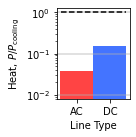

In [8]:
# Heat Opt - 4K
fig, axs = plt.subplots(figsize=(2, 2))

axs.bar(0, load_matrices[2].iloc[[0, 3], 1].sum(), width=1, color='#FF4444')
axs.bar(1, load_matrices[2].iloc[[1, 4], 1].sum(), width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-3, 1.3)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat, '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Line Type")

plt.tight_layout()

# plt.savefig('Switchable/Opt4K.png', dpi=400, transparent=True)
plt.savefig('AIP Congress/Opt4K.png', dpi=400, transparent=True)

plt.show()

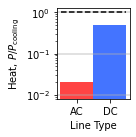

In [10]:
# Heat Opt - MXC
fig, axs = plt.subplots(figsize=(2, 2))

axs.bar(0, load_matrices[2].iloc[[0, 3], 4].sum(), width=1, color='#FF4444')
axs.bar(1, load_matrices[2].iloc[[1, 4], 4].sum(), width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-3, 1.3)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat, '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/OptMXC.png', dpi=400, transparent=True)

plt.show()

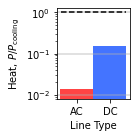

In [11]:
# Heat Switch1 - 4K
fig, axs = plt.subplots(figsize=(2, 2))

axs.bar(0, load_matrices[0].iloc[[0, 3], 1].sum(), width=1, color='#FF4444')
axs.bar(1, load_matrices[0].iloc[[1, 4], 1].sum(), width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-3, 1.3)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat, '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/14K.png', dpi=400, transparent=True)

plt.show()

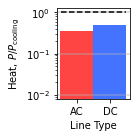

In [13]:
# Heat Switch1 - MXC
fig, axs = plt.subplots(figsize=(2, 2))

axs.bar(0, load_matrices[0].iloc[[0, 3], 4].sum(), width=1, color='#FF4444')
axs.bar(1, load_matrices[0].iloc[[1, 4], 4].sum(), width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-3, 1.3)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat, '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/1MXC.png', dpi=400, transparent=True)

plt.show()

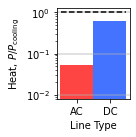

In [14]:
# Heat Switch2 - 4K
fig, axs = plt.subplots(figsize=(2, 2))

axs.bar(0, load_matrices[1].iloc[[0, 3], 1].sum(), width=1, color='#FF4444')
axs.bar(1, load_matrices[1].iloc[[1, 4], 1].sum(), width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-3, 1.3)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat, '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/24K.png', dpi=400, transparent=True)

plt.show()

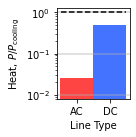

In [15]:
# Heat Switch2 - MXC
fig, axs = plt.subplots(figsize=(2, 2))

axs.bar(0, load_matrices[1].iloc[[0, 3], 4].sum(), width=1, color='#FF4444')
axs.bar(1, load_matrices[1].iloc[[1, 4], 4].sum(), width=1, color='#4474FF')

axs.set_yscale('log')
axs.set_ylim(8e-3, 1.3)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Heat, '+ r'$P/P_\mathrm{cooling}$')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/2MXC.png', dpi=400, transparent=True)

plt.show()

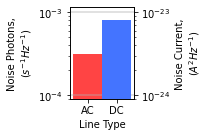

In [17]:
#Opt Noise
fig, axs = plt.subplots(figsize=(3, 2))

axs.bar(0, n_data_drive[2], width=1, color='#FF4444')

axs2 = axs.twinx()
axs2.bar(1, n_data_flux[2], width=1, color='#4474FF')

axs.set_yscale('log')
axs2.set_yscale('log')
axs.set_ylim(9e-5, 1.15e-3)
axs2.set_ylim(9e-25, 1.15e-23)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
# axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Noise Photons,\n' + r'($s^{-1}Hz^{-1}$)')
axs2.set_ylabel('Noise Current,\n' + r'($A^2 Hz^{-1}$)')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/OptNoise.png', dpi=400, transparent=True)

plt.show()

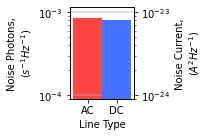

In [18]:
#1 Noise
fig, axs = plt.subplots(figsize=(3, 2))

axs.bar(0, n_data_drive[0], width=1, color='#FF4444')

axs2 = axs.twinx()
axs2.bar(1, n_data_flux[0], width=1, color='#4474FF')

axs.set_yscale('log')
axs2.set_yscale('log')
axs.set_ylim(9e-5, 1.15e-3)
axs2.set_ylim(9e-25, 1.15e-23)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
# axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Noise Photons,\n' + r'($s^{-1}Hz^{-1}$)')
axs2.set_ylabel('Noise Current,\n' + r'($A^2 Hz^{-1}$)')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/1Noise.png', dpi=400, transparent=True)

plt.show()

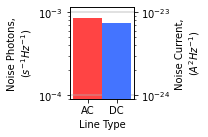

In [19]:
#2 Noise
fig, axs = plt.subplots(figsize=(3, 2))

axs.bar(0, n_data_drive[1], width=1, color='#FF4444')

axs2 = axs.twinx()
axs2.bar(1, n_data_flux[1], width=1, color='#4474FF')

axs.set_yscale('log')
axs2.set_yscale('log')
axs.set_ylim(9e-5, 1.15e-3)
axs2.set_ylim(9e-25, 1.15e-23)
axs.set_xticks([0, 1])
axs.set_xticklabels(['AC', 'DC'], rotation=0)
axs.grid(True, 'major', 'y', alpha=0.5, linewidth=1.5)
# axs.axhline(1, 0.05, 0.95, c='k', linestyle='dashed')

axs.set_ylabel('Noise Photons,\n' + r'($s^{-1}Hz^{-1}$)')
axs2.set_ylabel('Noise Current,\n' + r'($A^2 Hz^{-1}$)')
axs.set_xlabel("Line Type")

plt.tight_layout()

plt.savefig('AIP Congress/2Noise.png', dpi=400, transparent=True)

plt.show()

## Eccosorb

In [4]:
a = [0, 0, 0, 0, 0, 0, 0.04, 0.57, 2.2, 10.8, 13.2, 24.9]
f = np.array([1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 3, 8.6, 10, 18])*1e9

fig, axs = plt.subplots(figsize=(5, 3))

axs.plot(f, a, c='r')
axs.set_xscale('log')

axs.set_xlabel('Frequency')
axs.set_ylabel('Attenuation (dB/cm)')
axs.set_title('Eccosorb Frequency Response')
axs.grid(True, 'major', 'both')

plt.tight_layout(True)

plt.savefig('Eccosorb.png', dpi=400, transparent=True)

plt.show()